# CEE 690-02

# Environmental Spatial Data Analysis

# Lecture 21

# Logistics

* Homework #7 due this Thursday
* Homework #8 will be up on Saturday

# Outline

* Inverse distance weighting
* Simple Kriging
* Covariance function

# Let's go back to the sand map we explored last week

In [1]:
import xarray as xr
import numpy as np
fp = xr.open_rasterio('../Workspace/sand_0_5.tif')
data = np.array(fp[0,:,:])
y = np.array(fp['y'][:])
x = np.array(fp['x'][:])
fp.close()

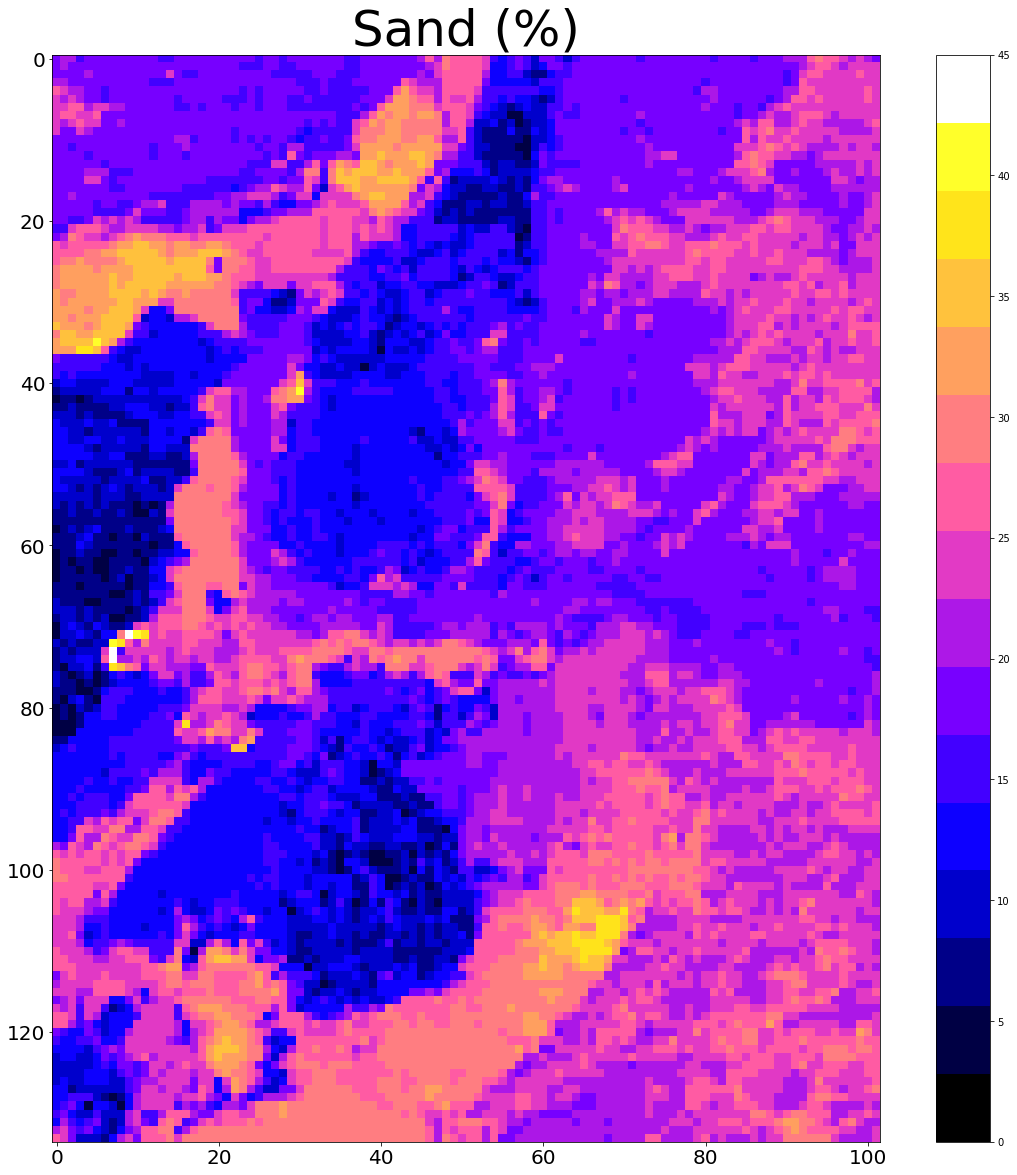

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
data = np.ma.masked_array(data,data<0)
vmin = 0
vmax = 45
plt.figure(figsize=(20,20))
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Sand (%)',fontsize=50)
plt.colorbar()
plt.show()

# What if we didn't have the entire map?

In [3]:
#Let's randomly sample n different points
nsamples = int(0.1*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

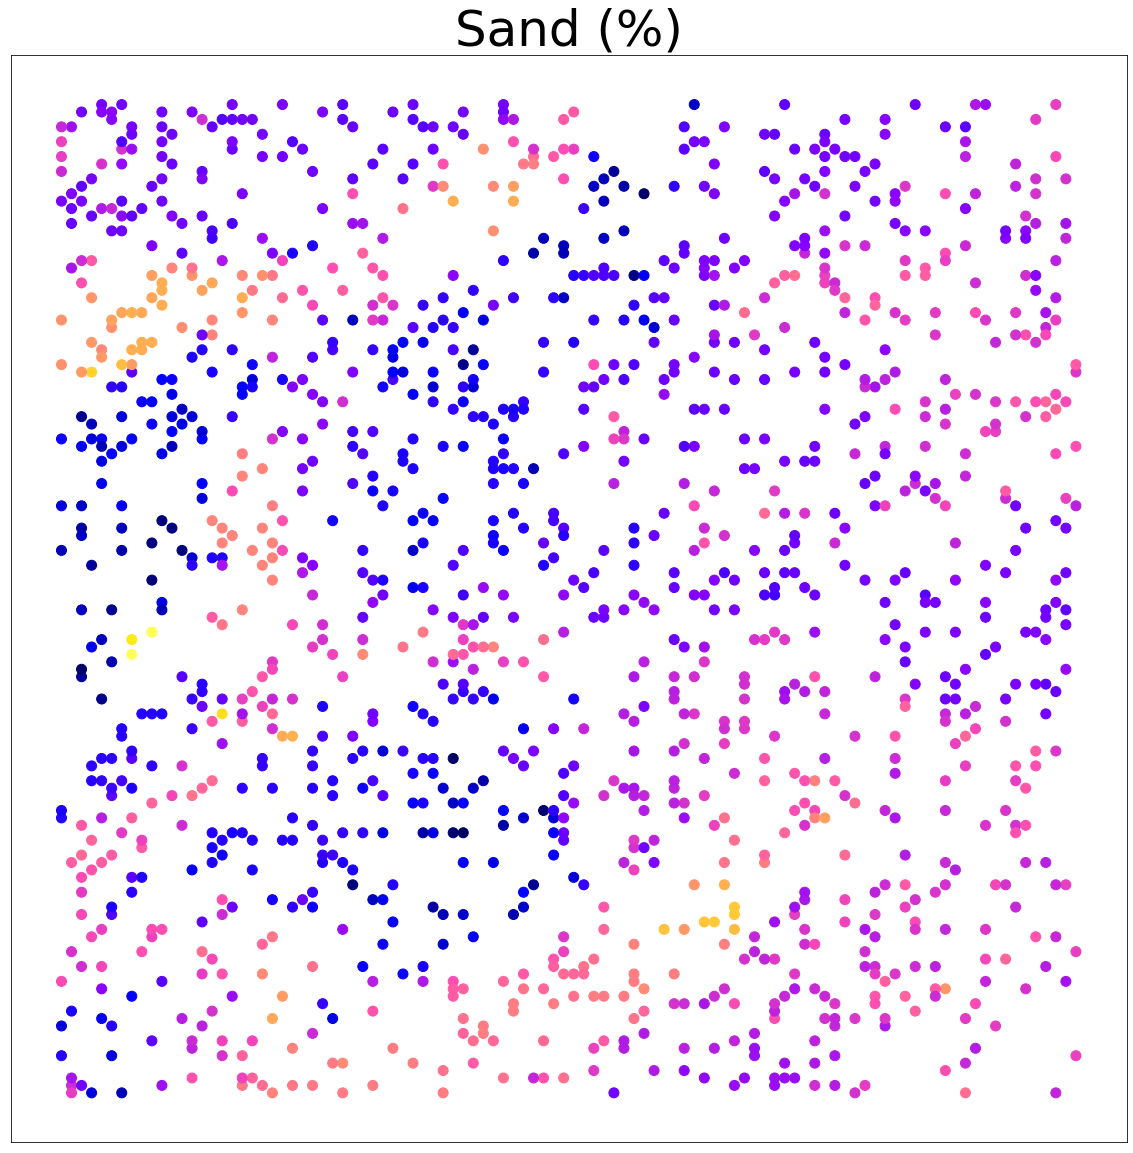

In [4]:
#Make a scatter plot of the data
plt.figure(figsize=(20,20))
plt.scatter(ix,np.max(iy)-iy,c=data_points,s=100,vmin=vmin,vmax=vmax,cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
plt.show()

# How can we reproduce the original "true" map with the point data based on proximity to other points?

This is the basis of distance-based spatial interpolation

# Let's first explore this problem in 1d

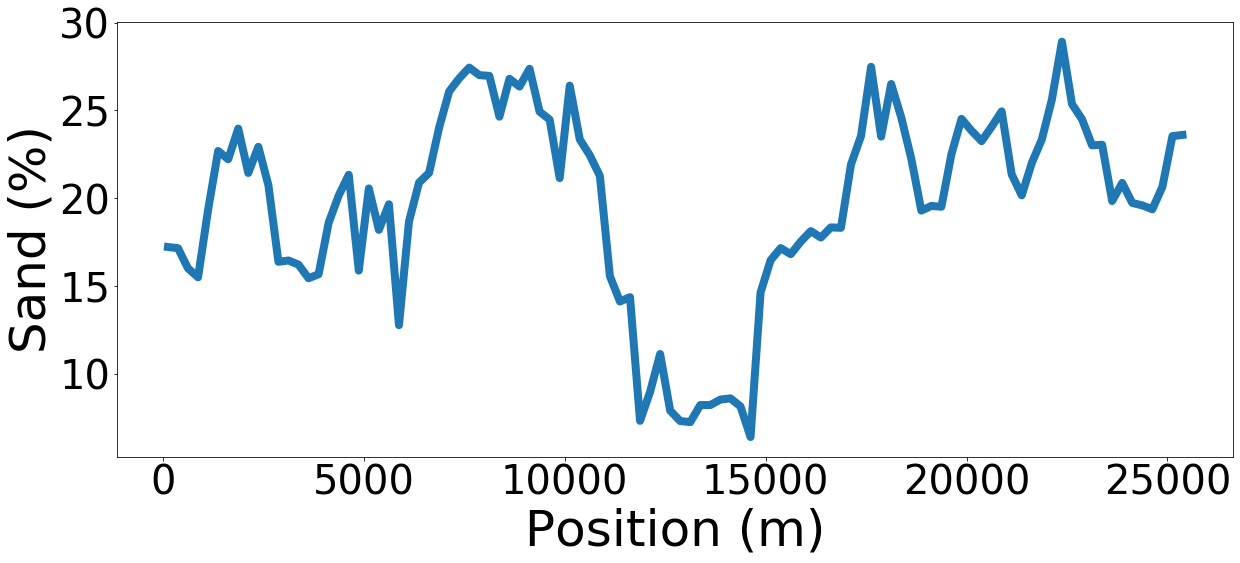

In [5]:
data1d = data[20,:]
pos = 250*np.arange(data1d.size) + 250.0/2 
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.show()

# Let's sample from our data (mimic field sampling)

In [6]:
import sklearn.model_selection
import numpy as np
X = pos[:,np.newaxis]
y = data1d
(Xt,Xv,yt,yv) = sklearn.model_selection.train_test_split(X,y,test_size=0.8,random_state=2,shuffle=True)

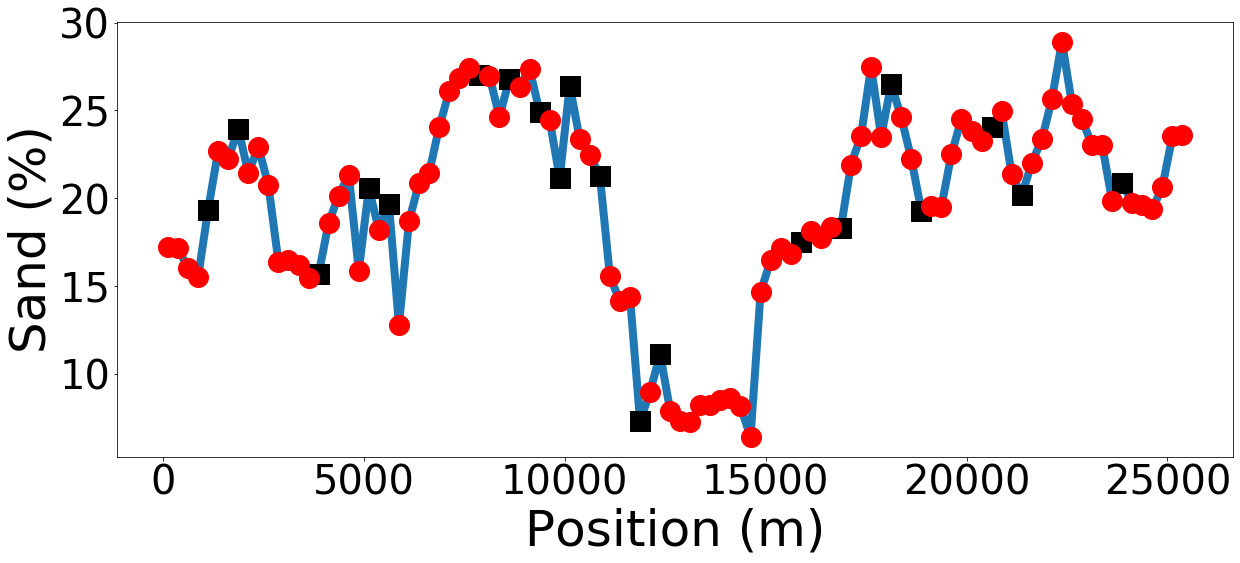

In [7]:
data1d = data[20,:]
pos = 250*np.arange(data1d.size) + 250.0/2 
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8)
plt.plot(Xt[:,0],yt,'ks',markersize=20)
plt.plot(Xv[:,0],yv,'ro',markersize=20)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.show()

We know the black squares but don't know the red dots

# Nearest neighbor interpolation

$$z^*(\mathbf{x}_0) = z(\mathbf{x}_i)$$

where $z(\mathbf{x}_i)$ is the closest observation to $\mathbf{x}_0$. 

* Note that $z^*(\mathbf{x}_0)$ is the estimate of the true unknown value $z(\mathbf{x}_0)$.

* For simplicity, moving forward we will use $z^*$, $z_0$, and $z_i$ instead of $z^*(\mathbf{x}_0)$, $z(\mathbf{x}_0)$ , and $z(\mathbf{x}_i)$. However, they mean the same thing.



# Let's explore nearest neighbor interpolation for our 1d example

# Distance between observations and data.

In [8]:
#Calculate distance between an unknown point and all the observations
ipoint = 0
dist = Xt[:,0]-Xv[ipoint,:] #Distance array

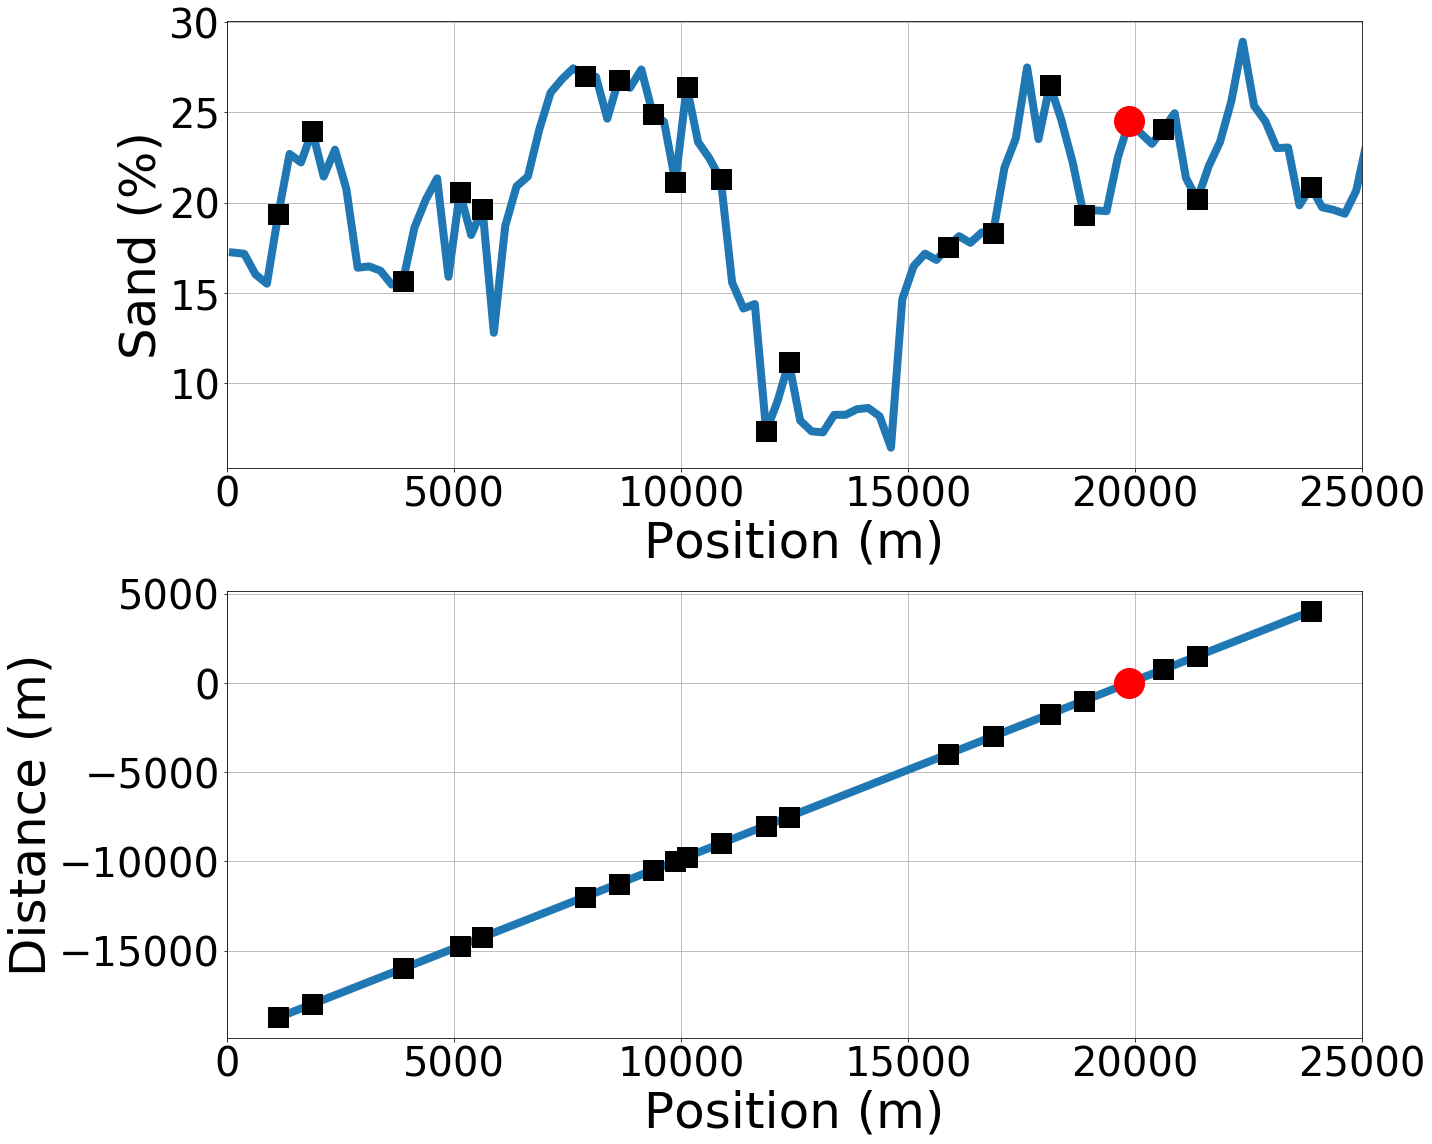

In [9]:
#Make a plot showing the placement of the unknown value and it's proximity to other values
plt.figure(figsize=(20,16))
plt.subplot(212)
argsort = np.argsort(Xt[:,0])
plt.plot(Xt[argsort,0],dist[argsort],lw=8)
plt.plot(Xt[argsort,0],dist[argsort],'ks',markersize=20)
plt.plot(Xv[ipoint,0],0,'ro',markersize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Distance (m)',fontsize=50)
plt.xlim([0,25000])
plt.grid('on')
plt.subplot(211)
plt.plot(pos,data1d,lw=8)
plt.plot(Xt[:,0],yt,'ks',markersize=20)
plt.plot(Xv[ipoint,0],yv[ipoint],'ro',markersize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.grid('on')
plt.tight_layout()
plt.show()

# Use nearest neighbor interpolation to predict all the missing points

In [10]:
#Sites left out
dist = np.abs(Xt.T-Xv) #Compute the distance between all observations and all missing data points
inn = np.argmin(dist,axis=1) #Determine the closest observation to each point
ypred = yt[inn] #Interpolate

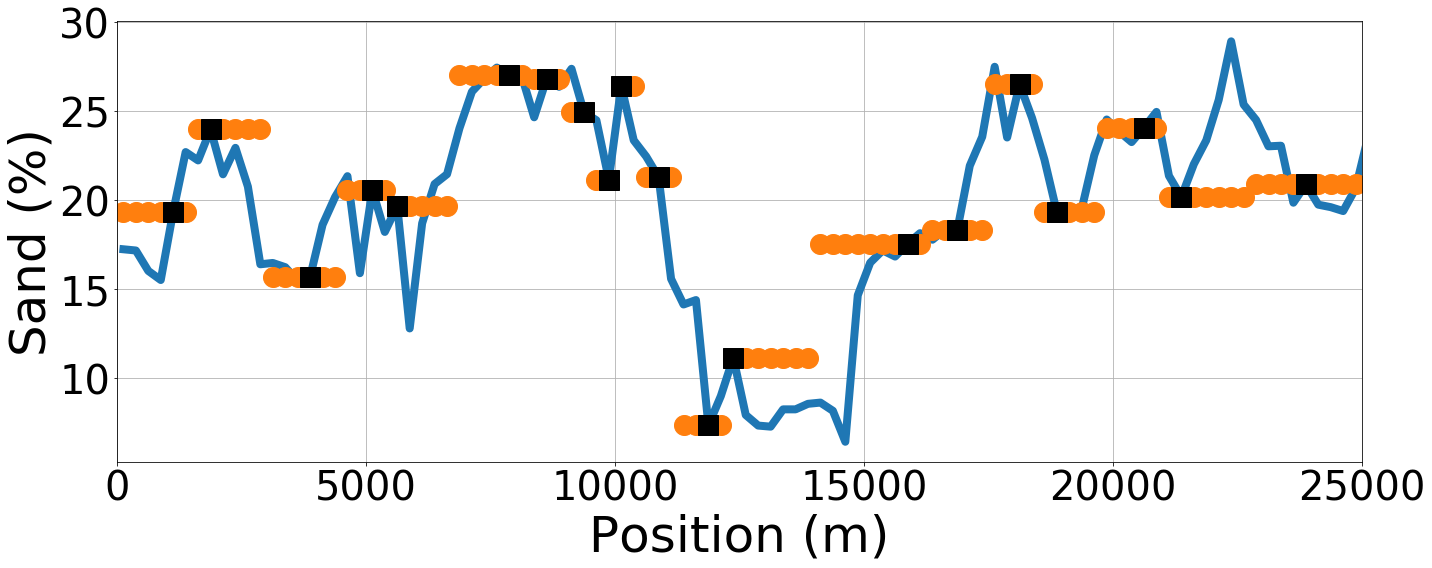

In [11]:
#Plot the predictions
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8)
plt.plot(Xv[:,0],ypred,'o',markersize=20)
plt.plot(Xt[:,0],yt,'ks',markersize=20)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.grid('on')
plt.tight_layout()
plt.show()

In [12]:
#Evaluate performance
import sklearn.metrics
print(r'R2: %f' % sklearn.metrics.r2_score(yv,ypred))

R2: 0.595086


# How could we change our interpolation scheme to make it smoother? 

# Linear combination of observations

$$z^* = \sum_{i=1}^N w_i z_i$$

Many careers have been built on figuring out how to determine the optimal weights ($w_i$)?

# Let's start with the simplest case: Inverse distance weighting

# Inverse distance weighting (IDW)

$$w_i = \frac{h_{i,0}^{-p}}{\sum_{j=1}^Nh_{i,0}^{-p}}$$

where $h = ||\mathbf{x_i} - \mathbf{x_0}||$ and $p$ is a user defined parameter.

Then, we can immediately estimate $z^*$:

$$z^* = \sum_{i=1}^N \left(\frac{\frac{1}{h_{i,0}^{-p}}}{\sum_{j=1}^Nh_{i,0}^{-p}}\right) z_i$$

Note: IDW is also known as Shephard's method.

# IDW example

In [13]:
#Inverse distance weighting function
def inverse_distance_weighting(dist,yt,p=2.0):
    weights = (1/dist**p)/np.sum(1/dist**p,axis=1)[:,np.newaxis]
    ypred = np.sum(weights*yt,axis=1)
    return ypred

In [14]:
#Make prediction
ypred = inverse_distance_weighting(dist,yt,p=2.0)

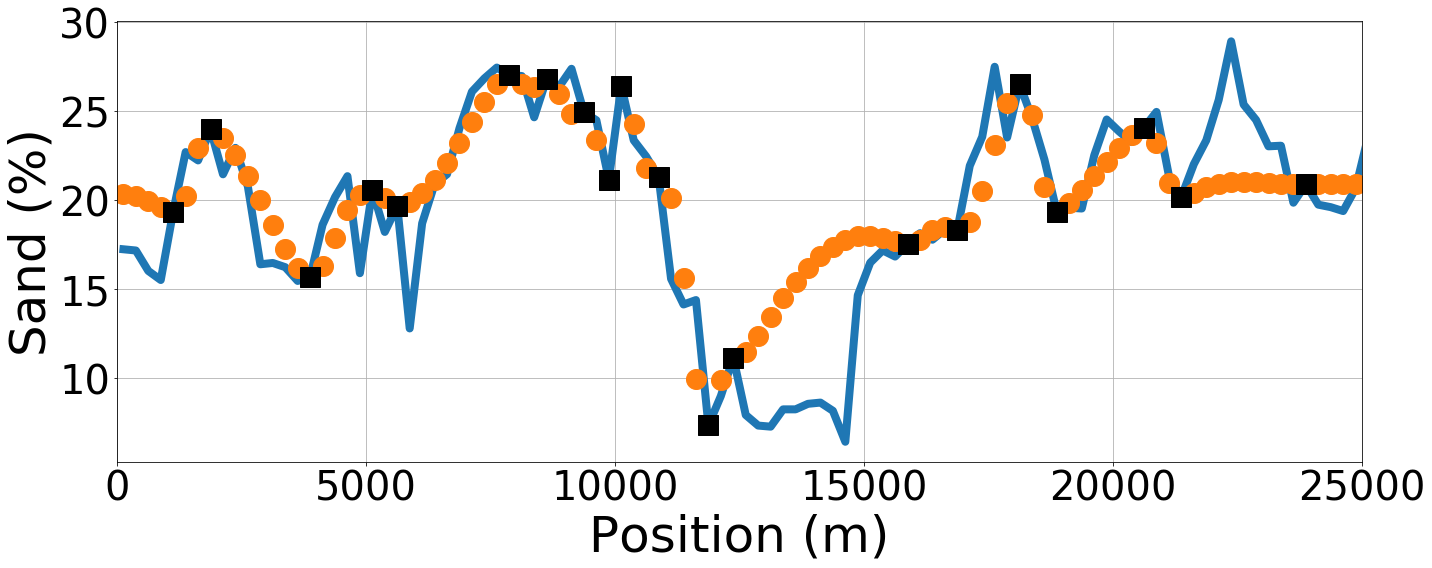

In [15]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8)
plt.plot(Xv[:,0],ypred,'o',markersize=20)
plt.plot(Xt[:,0],yt,'ks',markersize=20)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.grid('on')
plt.tight_layout()
plt.show()

In [16]:
print(r'R2: %f' % sklearn.metrics.r2_score(yv,ypred))

R2: 0.623432


# What is the role of p?

R2: -0.012539
R2: 0.623432
R2: 0.685101


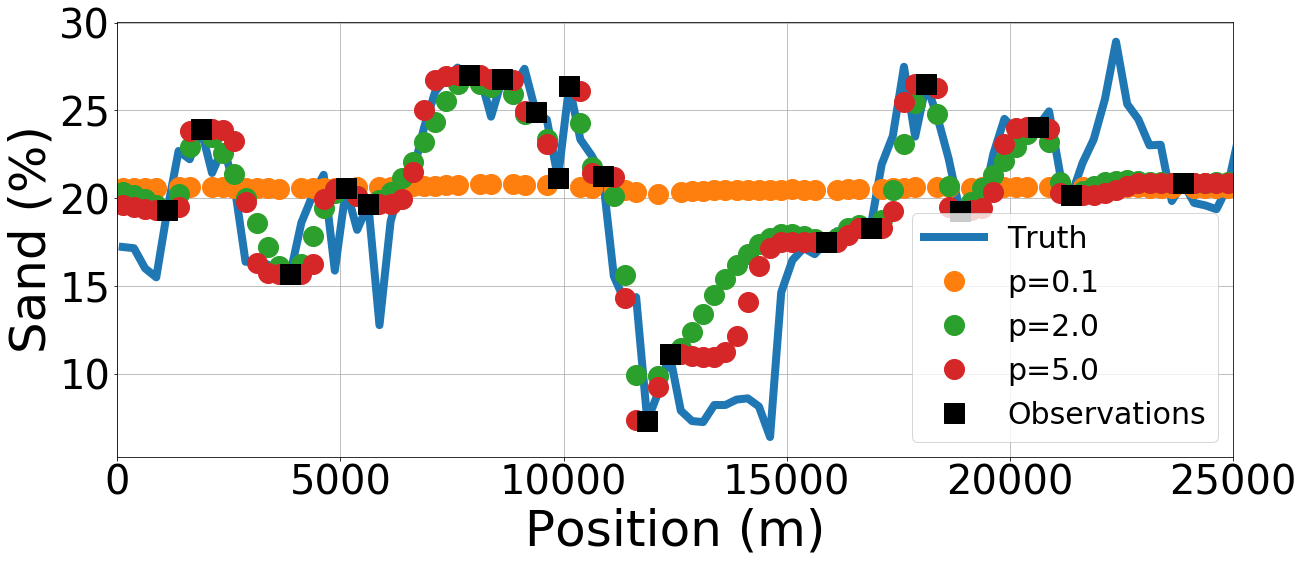

In [17]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8)
for p in [0.1,2.0,5.0]:
    ypred = inverse_distance_weighting(dist,yt,p=p)
    plt.plot(Xv[:,0],inverse_distance_weighting(dist,yt,p=p),'o',markersize=20)
    print(r'R2: %f' % sklearn.metrics.r2_score(yv,ypred))
plt.plot(Xt[:,0],yt,'ks',markersize=20)
plt.legend(['Truth','p=0.1','p=2.0','p=5.0','Observations'],fontsize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.grid('on')
plt.show()
    

Interpretation: Lower $p$ leads to smoothing (all observations matter), while higher $p$ leads to more local interpolation (only close observations matter).

# Intuition about the p parameter

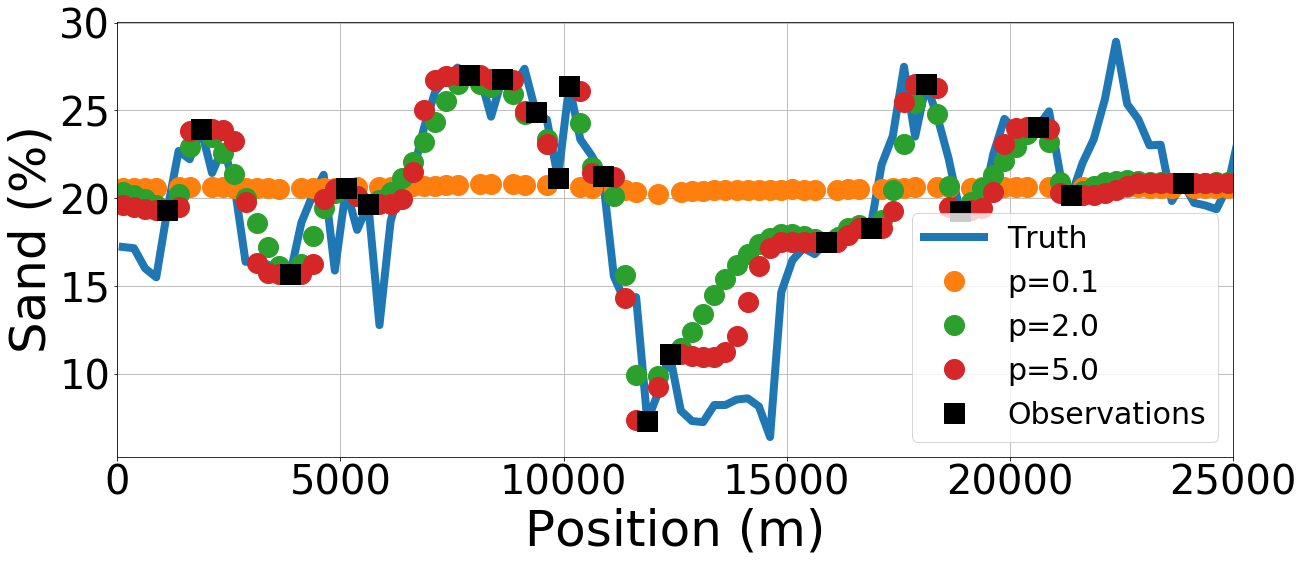

What is the p parameter actually informing IDW about?

# Pros/cons of IDW: 
* Very easy to implement
* Definitely better than nearest neighbor
* Can get good local results when we find the optimal p
* Problem: p values are fairly ad-hoc and hard to define
* Does not account for actual spatial properties of the system

# Kriging: Motivation

Can we create an alternative to IDW that accounts objectively (not just guessing) for the spatial correlation of points in space when assembling the weights for the linear estimator? 

Yes! That's Kriging.

We are going to start with what is known as **Simple Kriging**.

# Origins of Kriging 

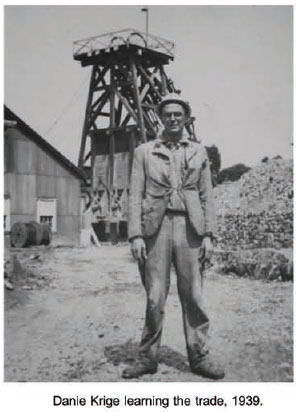

**Per Wikipedia**: Daniel Krige was a South African statistician and mining engineer who pioneered the field of geostatistics and was professor at the University of the Witwatersrand in South Africa. The technique of kriging is named after him. Krige's empirical work to evaluate mineral resources was formalised in the 1960s by French engineer Georges Matheron.

# Simple Kriging: Kriging with a known mean

* For simple kriging we assume that we already know the spatial mean (which is a generally problematic assumption). 

* We can then effectivly translate our data by subtracting the mean and thus convert our data to 0 mean. We will assume this is the case for the following derivation. 


# Redefining z*

Let's reframe $z$ as being a realization of the random variable $Z$.

Then we can redefine our linear estimator $z^* = \sum_{i=1}^N w_i z_i$ as:

$$Z^* = \sum_{i=1}^N w_i Z_i$$

# Let's find a more objective way to compute our weights

# Mean squared error (MSE)

The mean squared error of our estimator $Z*$ with respect to its truth $Z_0$ is defined as:

$$\text{MSE} = \mathbb{E}(Z^* - Z_0)^2$$


Our goal is going to be to minimize the MSE to find the weights $w_i$.

# Expanding the expectation

$$\mathbb{E}[(Z^* - Z_0)^2] = \mathbb{E}[Z^*Z^*] - 2\mathbb{E}[Z^*Z_0] + \mathbb{E}[Z_0Z_0]$$

Where:

$$\mathbb{E}[Z_0Z_0] = \text{Var}(Z_0)$$

$$\mathbb{E}[Z^*Z_0] = \sum_{i=1}^N w_i \mathbb{E}[Z_iZ_0] = \sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0)\$$

$$\mathbb{E}[Z^*Z^*] = \sum_{i=1}^N \sum_{j=1}^N w_i w_j \mathbb{E}[Z_iZ_j] = \sum_{i=1}^N \sum_{j=1}^N w_i w_j \text{Cov}(Z_i,Z_j)$$

Thus: 

$$\mathbb{E}[(Z^* - Z_0)^2] = \sum_{i=1}^N \sum_{j=1}^N w_i w_j \text{Cov}(Z_i,Z_j) - 2\sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0) + \text{Var}(Z_0)$$

# Checkpoint: Gain some intuition

* $\text{Cov}(Z_i,Z_j)$
* $\text{Cov}(Z_i,Z_0)$
* $\text{Var}(Z_0)$

# Objective: Minimize the Mean Squared Error

$$\frac{\partial}{\partial w_i}\left(\mathbb{E}[(Z^* - Z_0)^2]\right) = \frac{\partial}{\partial w_i}\left(\sum_{i=1}^N \sum_{j=1}^N w_i w_j \text{Cov}(Z_i,Z_j) - 2\sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0) + \text{Var}(Z_0)\right) = 0$$ 

Take partial derivatives with respect to $w_j$ to obtain:

$$2\sum_{j=1}^Nw_j\text{Cov}(Z_i,Z_j) - 2\text{Cov}(Z_i,Z_0) = 0$$

Simplify and rearrange:

$$\sum_{j=1}^Nw_j\text{Cov}(Z_i,Z_j) = \text{Cov}(Z_i,Z_0)$$

Reformulate into matrix form:

$$\mathbf{\Sigma} \mathbf{w} = \mathbf{c}$$

Where $\mathbf{w}$ is the vector of weights, $\mathbf{\Sigma}$ is the covariance matrix between all the observations, and $\mathbf{c}$ is the vector of covariances between $Z_0$ and all observations $Z_i$.

# Computing the weights

Determining the linear weights for a given point reduces to solving the linear system for $\mathbf{w}$:

$$\mathbf{\Sigma} \mathbf{w} = \mathbf{c}$$

This might seem scary at first, but since it is already in the form $\mathbf{A}\mathbf{x} = \mathbf{b}$ then any linear solver can solve immediately (assuming that our covariance matrix is positive-definite which we will ensure). 

Note that this system will only give us the weights when estimating a single point $z^*$. This same system needs to be solved for all points where we interpolate to (i.e., we need a new set of weights).

# Deeper meaning?

$$\mathbf{\Sigma} \mathbf{w} = \mathbf{c}$$

The covariance matrix $\mathbf{\Sigma}$ is telling us how the observations relate to each other. This allows us to maximize information from less common observations when necessary. The covariance vector $\mathbf{c}$ then tell us about how a given unobserved point relates to the observations.

# Deriving the covariance matrix and covariance vector

We are defining covariance solely as a function of absolute distance $|h|$ between $Z_i$ and $Z_j$.

For convenience, we will assume moving forward that $h = |h|$.

We can then use a covariance function to define a relationship between covariance and distance:

$$\text{Cov}(Z,Z+h) = f(h)$$

On Thursday we will explore these functions in more detail, however, for now we will just use the exponential covariance function.

$$\text{Cov}(Z,Z+h) = \sigma^2exp^{-h/\tau}$$

Where $\sigma^2$ is the variance of $Z$ and $\tau$ is a parameter that informs how quickly the covariance decays.

# Examples of the exponential covariance function

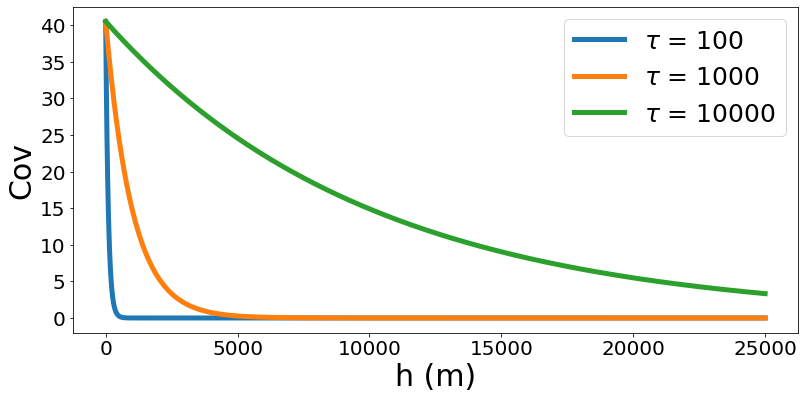

In [18]:
# Impact of the parameters of the covariance function
var = np.var(data)
dist = np.linspace(0,25000,1000)
plt.figure(figsize=(13,6))
for tau in [100,1000,10000]:
    cov = var*np.exp(-dist/tau)
    plt.plot(dist,cov,lw=5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('h (m)',fontsize=30)
plt.ylabel('Cov',fontsize=30)
plt.legend([r'$\tau$ = 100',r'$\tau$ = 1000',r'$\tau$ = 10000'],fontsize=25)
plt.show()

Gain intuition: What could be the relationship between $\tau$ in the exponential covariance function and the $p$ in IDW?

# Let's construct our covariance matrix

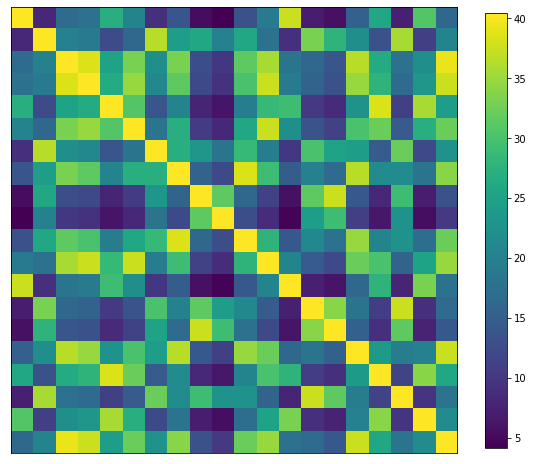

In [19]:
dist = np.abs(Xt[:].T - Xt[:])
Sigma = var*np.exp(-dist/tau)
plt.figure(figsize=(10,10))
plt.imshow(Sigma)
plt.colorbar(shrink=0.8)
plt.xticks([])
plt.yticks([])
plt.show()

Remember: This is just the spatial covariance between our observations

# We can also construct the covariance vector

The values are plotted on top of the place where the observations are so you can get an idea of how distance plays a role here. 

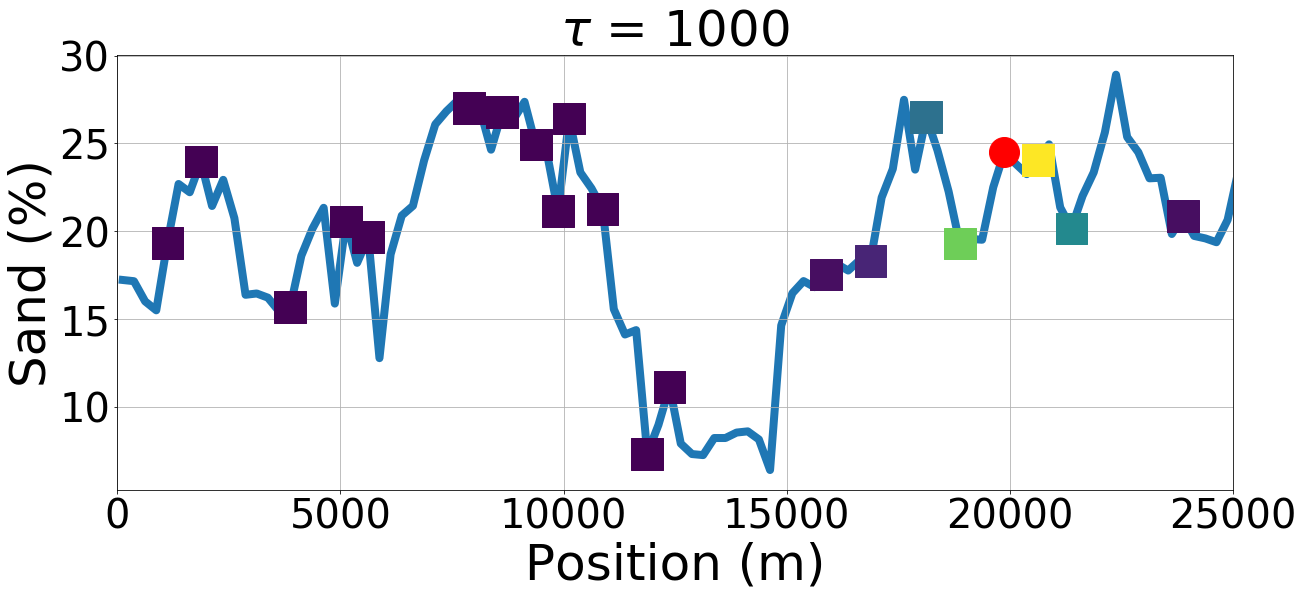

In [20]:
tau = 1000
dist = np.abs(Xt[:] - Xv[0,:])
c = var*np.exp(-dist/tau)[:,0]
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
plt.plot(Xv[ipoint,0],yv[ipoint],'ro',markersize=30)
plt.scatter(Xt[:,0],yt,c=c,marker='s',s=1000,zorder=2)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.title(r'$\tau$ = 1000',fontsize=50)
plt.grid('on')

# The $\tau$ parameter matters...

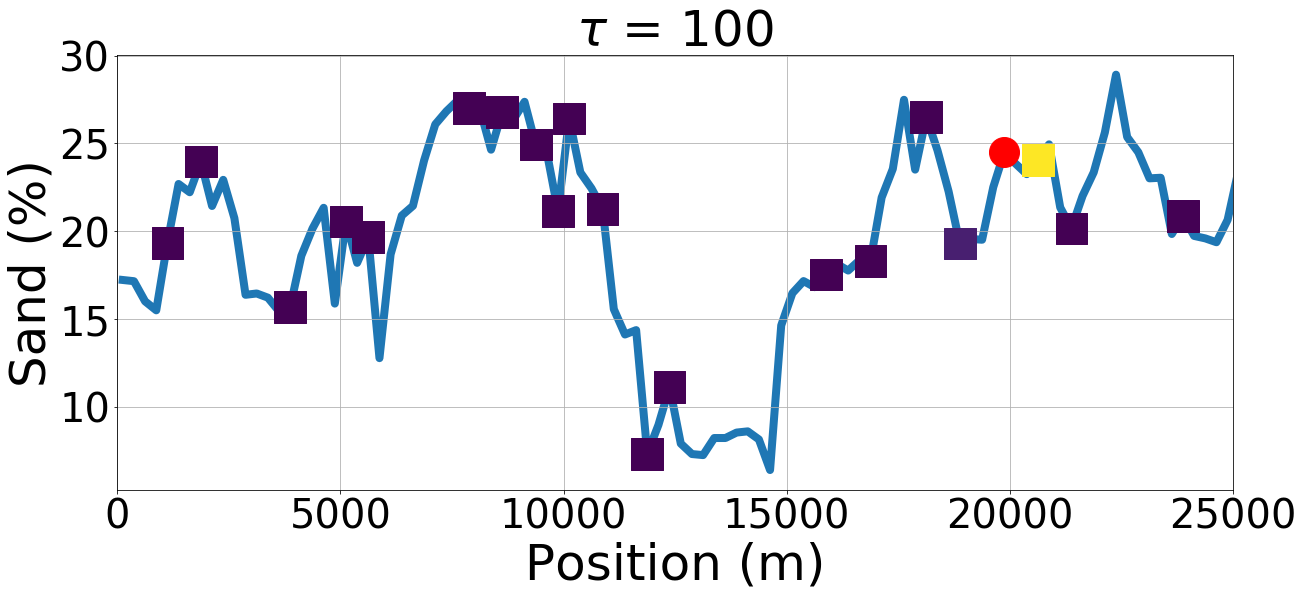

In [21]:
tau = 100
dist = np.abs(Xt[:] - Xv[0,:])
c = var*np.exp(-dist/tau)[:,0]
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
plt.plot(Xv[ipoint,0],yv[ipoint],'ro',markersize=30)
plt.scatter(Xt[:,0],yt,c=c,marker='s',s=1000,zorder=2)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.title(r'$\tau$ = 100',fontsize=50)
plt.grid('on')

Remember: This covariance vector is only between the observations $Z_i$ and a single point $Z_0$ for which we aim to compute $z^*$. 

On Thursday we will dive deeper into assembling the covariance function (and the variograms) from data. 

# Let's now go back to Simple Kriging

We need to perform two tasks:

1. Determining the linear weights for a given point reduces to solving the linear system for $\mathbf{w}$:

$$\mathbf{\Sigma} \mathbf{w} = \mathbf{c}$$

2. Use those weights to compute $z^*$:

$$z^* = \mathbf{w}^T\mathbf{z} = \sum_{i=1}^Nw_iz_i$$

# Compute the weights ($\tau = 10000$)

In [22]:
tau = 10000
ipoint = 0
# Compute distance matrix between all points and all observations
dist = np.abs(Xt[:].T - Xv[ipoint,:])
# Compute covariance of unknown points with data
c = var*np.exp(-dist/tau).T
# Compute covariance of all observations with each other
dist = np.abs(Xt[:].T - Xt[:])
Sigma = var*np.exp(-dist/tau)
# Solve for the weights
weights = np.linalg.solve(Sigma,c)

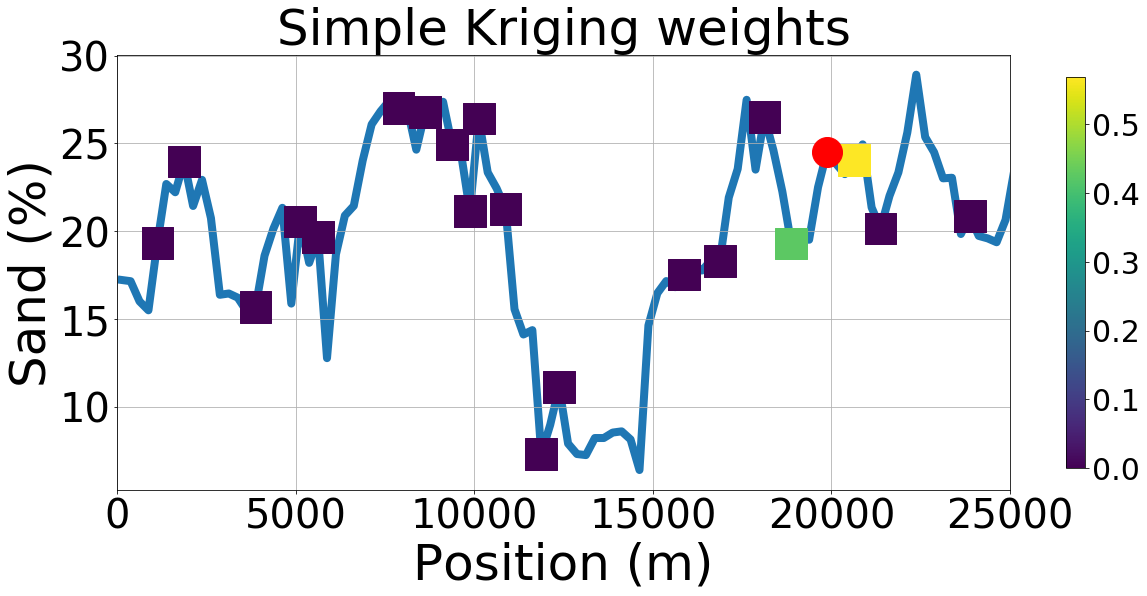

In [23]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
plt.plot(Xv[ipoint,0],yv[ipoint],'ro',markersize=30)
plt.scatter(Xt[:,0],yt,c=weights[:,0],marker='s',s=1000,zorder=2)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
cb = plt.colorbar(shrink=0.9)
cb.ax.tick_params(labelsize=30)
plt.title('Simple Kriging weights',fontsize=50)
plt.grid('on')

# Compute $z^*$

In [24]:
ipoint = 0
#Remove the known mean form yt to ensure 0 mean (Remember SK assumptions)
mu = np.mean(data1d)
zt = yt - mu
#Compute zstar
zstar = np.sum(weights[:,0]*zt)
#Add the mean back in
ystar = zstar + mu

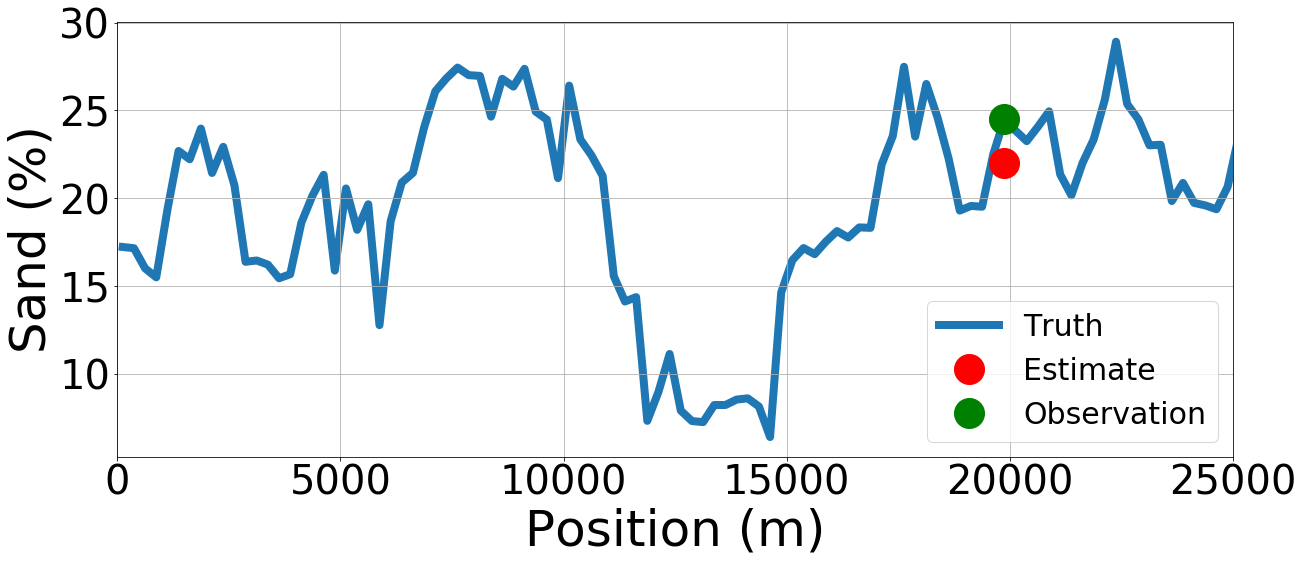

In [25]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
plt.plot(Xv[ipoint,0],ystar,'ro',markersize=30)
plt.plot(Xv[ipoint,0],yv[ipoint],'go',markersize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.title('',fontsize=50)
plt.grid('on')
plt.legend(['Truth','Estimate','Observation'],fontsize=30)
plt.show()

# Apply Simple Kriging for all missing points

The inefficient (yet intuitive) way first...

In [26]:
def simple_kriging_point(tau,Xt,Xv,mu,yt,ipoint):
    #Compute weights
    # Compute distance matrix between all points and all observations
    dist = np.abs(Xt[:].T - Xv[ipoint,:])
    # Compute covariance of unknown points with data
    c = var*np.exp(-dist/tau).T
    # Compute covariance of all observations with each other
    dist = np.abs(Xt[:].T - Xt[:])
    Sigma = var*np.exp(-dist/tau)
    # Solve for the weights
    weights = np.linalg.solve(Sigma,c)
    #Remove the known mean form yt to ensure 0 mean (Remember SK assumptions)
    zt = yt - mu
    #Compute zstar
    zstar = np.sum(weights[:,0]*zt)
    #Add the mean back in
    ystar = zstar + mu
    return ystar

#Define tau
tau = 10000
#Define mu 
mu = np.mean(data1d)
#Compute ystart for all missing points
ypred = []
for ipoint in range(yv.size):
    ypred.append(simple_kriging_point(tau,Xt,Xv,mu,yt,ipoint))
ypred = np.array(ypred)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
plt.plot(Xv[:,0],ypred,'ro',markersize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.title('',fontsize=50)
plt.grid('on')
plt.legend(['Truth','Estimate'],fontsize=30)
plt.show()

In [29]:
print(r'R2: %f' % sklearn.metrics.r2_score(yv,ypred))

R2: 0.713745


# Python will do the iteration for us

Instead of $\mathbf{w}$ and $\mathbf{c}$ being vectors, we instead can turn them into matrices $\mathbf{W}$ and $\mathbf{C}$ where each column corresponds to a different point that we are going to predict.

$$\mathbf{\Sigma} \mathbf{W} = \mathbf{C}$$

Python will just solve each system independently giving the exact same result.

In [30]:
def simple_kriging(tau,Xt,Xv,mu,yt):
    #Compute weights
    # Compute distance matrix between all points and all observations
    dist = np.abs(Xt[:].T - Xv[:])
    # Compute covariance of unknown points with data
    c = var*np.exp(-dist/tau).T
    # Compute covariance of all observations with each other
    dist = np.abs(Xt[:].T - Xt[:])
    Sigma = var*np.exp(-dist/tau)
    # Solve for the weights
    weights = np.linalg.solve(Sigma,c)
    #Remove the known mean form yt to ensure 0 mean (Remember SK assumptions)
    zt = yt - mu
    #Compute zstar
    zstar = np.sum(weights*zt[:,np.newaxis],axis=0)
    #Add the mean back in
    ystar = zstar + mu
    return ystar

#Define tau
tau = 10000
#Define mu 
mu = np.mean(data1d)
#Compute ystart for all missing points
ypred = simple_kriging(tau,Xt,Xv,mu,yt)

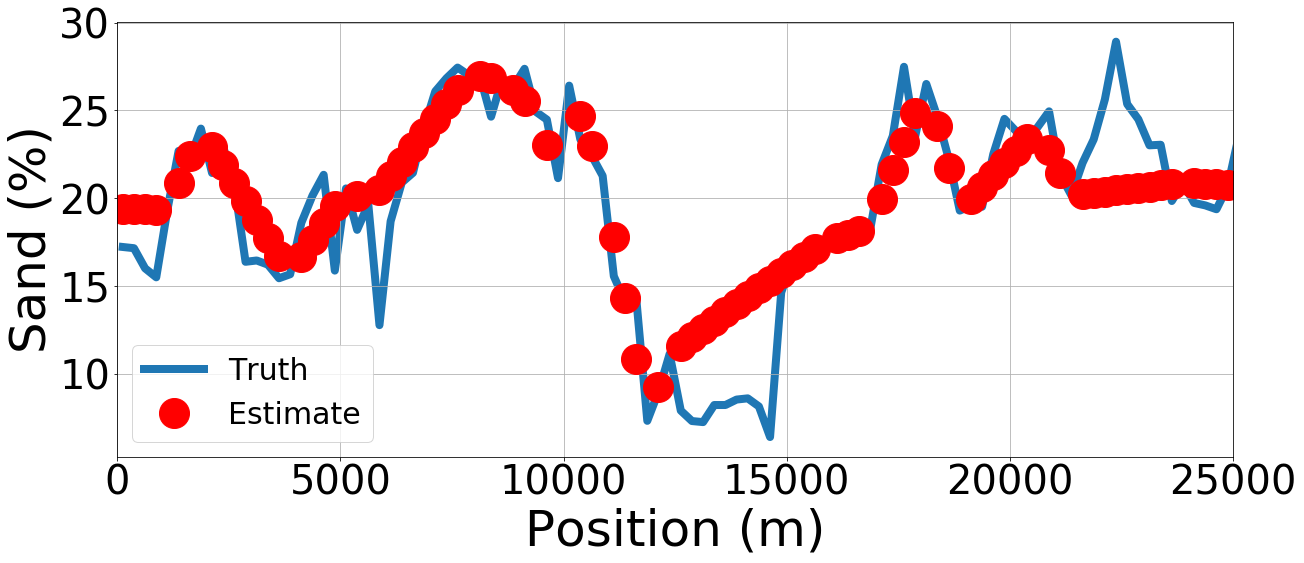

In [32]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
plt.plot(Xv[:,0],ypred,'ro',markersize=30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.title('',fontsize=50)
plt.grid('on')
plt.legend(['Truth','Estimate'],fontsize=30)
plt.show()

In [33]:
print(r'R2: %f' % sklearn.metrics.r2_score(yv,ypred))

R2: 0.713745


# Kriging gives more than just a deterministic estimate

Let's bring out the mean squared estimate again:

$$\mathbb{E}[(Z^* - Z_0)^2] = \sum_{i=1}^N \sum_{j=1}^N w_i w_j \text{Cov}(Z_i,Z_j) - 2\sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0) + \text{Var}(Z_0)$$

Minimizing MSE gaves us the following:

$$\sum_{j=1}^Nw_j\text{Cov}(Z_i,Z_j) = \text{Cov}(Z_i,Z_0)$$

Let's plug that in to our definition of MSE thus obtaining:

$$\mathbb{E}[(Z^* - Z_0)^2] = \sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0)  - 2\sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0) + \text{Var}(Z_0)$$

Which we can simplify to:

$$\mathbb{E}[(Z^* - Z_0)^2] = \text{Var}(Z_0) - \sum_{i=1}^N w_i \text{Cov}(Z_i,Z_0)$$

Knowing the covariance function and the weights allows us to compute the mean squared error in our predictions. 

**Gain some intuition**: What would be the MSE if we just draw a random value from $Z_0$? 

# Kriging variance (i.e., uncertainty) for our 1d example

In [34]:
def simple_kriging_mse(tau,Xt,Xv,mu,yt):
    #Compute weights
    # Compute distance matrix between all points and all observations
    dist = np.abs(Xt[:].T - Xv[:])
    # Compute covariance of unknown points with data
    c = var*np.exp(-dist/tau).T
    # Compute covariance of all observations with each other
    dist = np.abs(Xt[:].T - Xt[:])
    Sigma = var*np.exp(-dist/tau)
    # Solve for the weights
    weights = np.linalg.solve(Sigma,c)
    # Compute weighted covariance
    p2 = np.sum(weights*c,axis=0)
    # Compute mse 
    mse = var - p2 
    
    return mse

#Define tau
tau = 10000
#Compute ystart for all missing points
mse = simple_kriging_mse(tau,Xt,Xv,mu,yt)

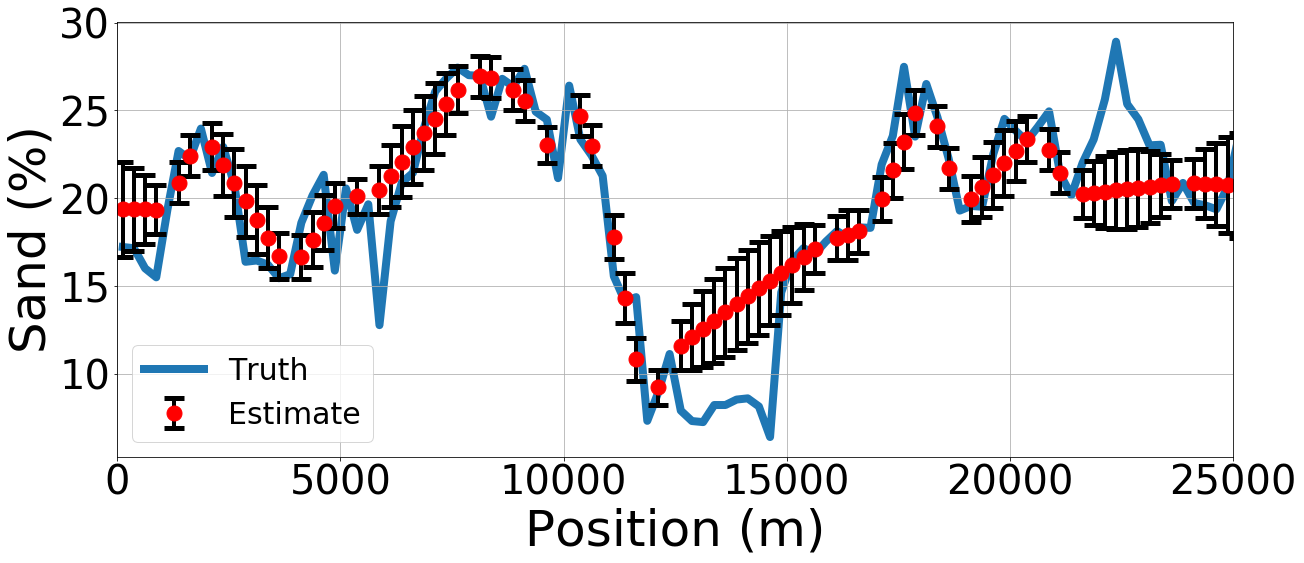

In [35]:
plt.figure(figsize=(20,8))
plt.plot(pos,data1d,lw=8,zorder=1)
argsort = np.argsort(Xv[:,0])
plt.errorbar(Xv[argsort,0],ypred[argsort],yerr=mse[argsort]**0.5,fmt='ro',
             ecolor='k',elinewidth=4,capthick=5,capsize=10,markersize=15)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlabel('Position (m)',fontsize=50)
plt.ylabel('Sand (%)',fontsize=50)
plt.xlim([0,25000])
plt.title('',fontsize=50)
plt.grid('on')
plt.legend(['Truth','Estimate'],fontsize=30)
plt.show()

# Let's take what we have done back to the 2d problem

# Map of points

In [36]:
import xarray as xr
import numpy as np
fp = xr.open_rasterio('../Workspace/sand_0_5.tif')
data = np.array(fp[0,:,:])
y = np.array(fp['y'][:])
x = np.array(fp['x'][:])
fp.close()

In [37]:
#Let's randomly sample n different points
nsamples = int(0.1*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

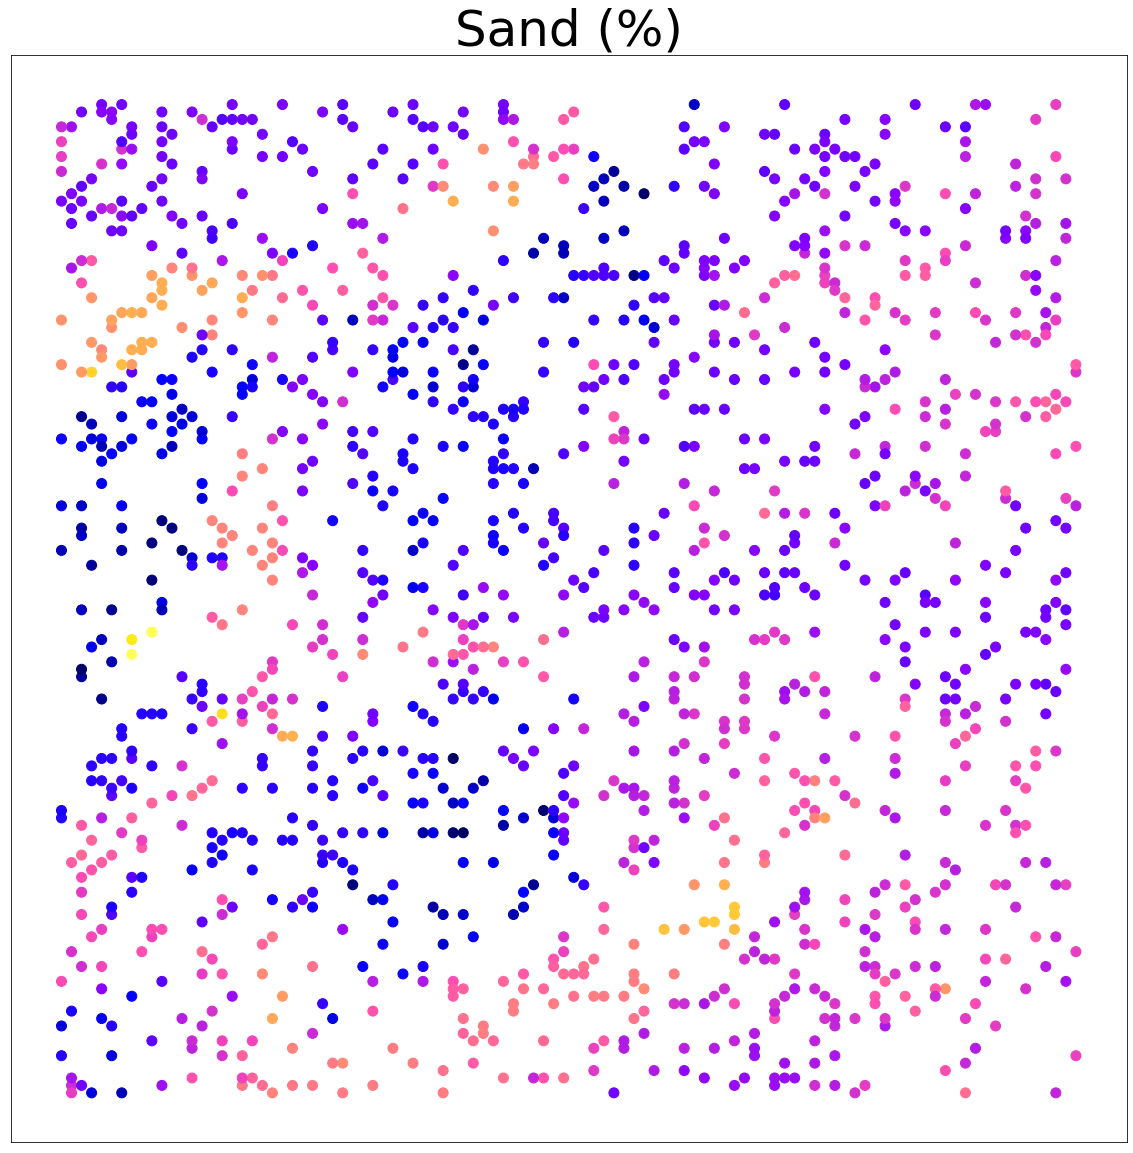

In [38]:
#Make a scatter plot of the data
plt.figure(figsize=(20,20))
plt.scatter(ix,np.max(iy)-iy,c=data_points,s=100,vmin=vmin,vmax=vmax,cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
plt.show()

# Critical assumption: Isotropic covariance function

* We will talk about this more on Thursday. It effectively allows us to use the same covariance function in all directions.

# Kriging estimate

In [39]:
#Define variance
var = np.var(data)
#Define mean
mu = np.mean(data)
#Define tau
tau = 10000
#Define grid positioning
x_grid = x[xs]
y_grid = y[ys]
#Let's reshape our data to a 1d array
xg1d = x_grid.reshape(x_grid.size)
yg1d = y_grid.reshape(y_grid.size)
#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5
#Compute covariance matrix C
C = var*np.exp(-dist/tau).T
#Compute euclidean distances from observatins to observations
dist = ((x_points[:,np.newaxis] - x_points.T)**2 + (y_points[:,np.newaxis] - y_points.T)**2)**0.5
#Compute covariance matrix Sigma
Sigma = var*np.exp(-dist/tau).T

In [40]:
#Solve for the weights
W = np.linalg.solve(Sigma,C)

In [41]:
#Subtract out the mean
zt = data_points - mu
#Assemble predictions
zstar = np.sum(W*zt[:,np.newaxis],axis=0)
#Add back in the mean
ystar = zstar + mu

# Compare the kriged map to the original one

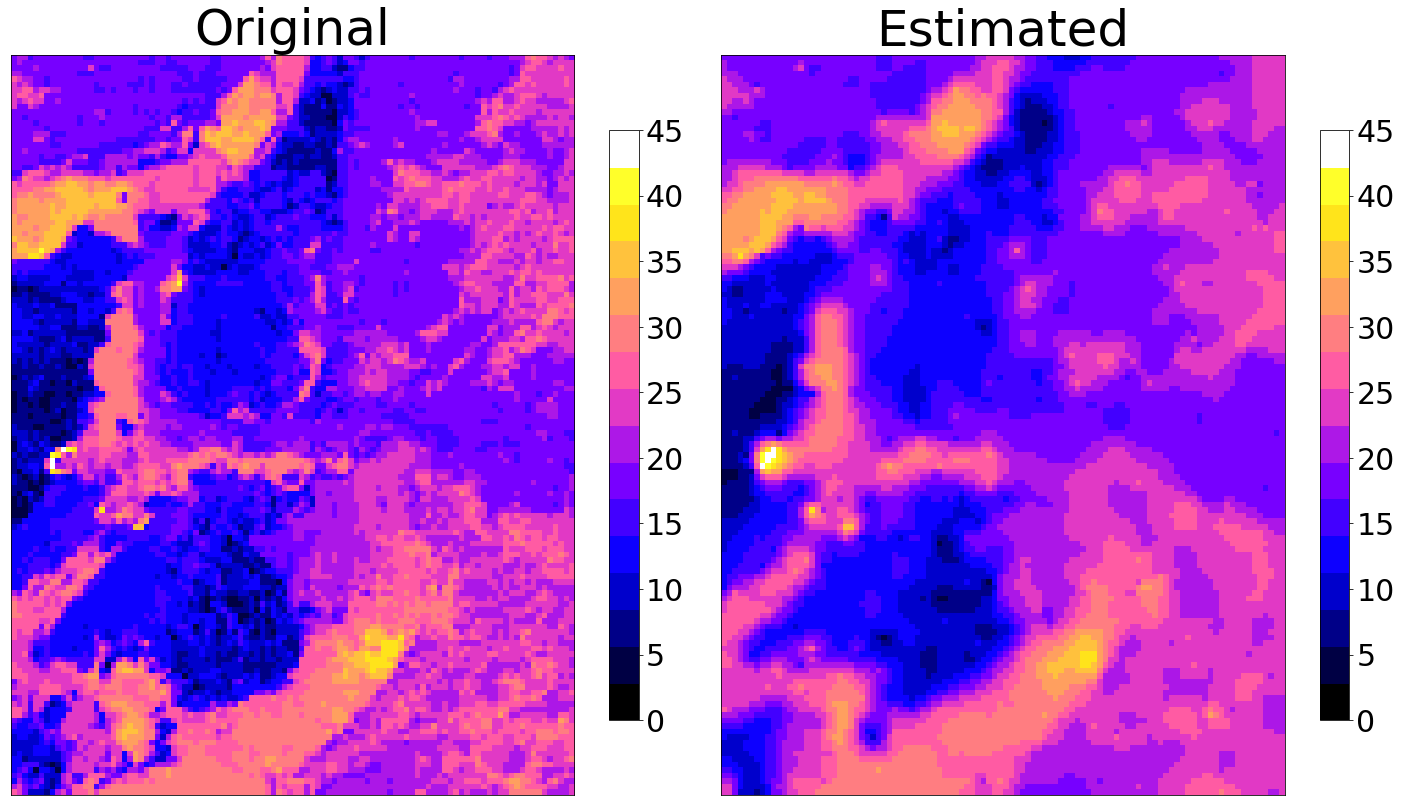

In [42]:
#Plot the original and kriged data side by side
ypred = ystar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

In [43]:
print(r'R2: %f' % sklearn.metrics.r2_score(data.reshape(data.size),ypred.reshape(ypred.size)))

R2: 0.812140


# Kriging variance (i.e., mean squared error)

In [44]:
# Compute weighted covariance
p2 = np.sum(W*C,axis=0)
# Compute mse 
mse = var - p2 

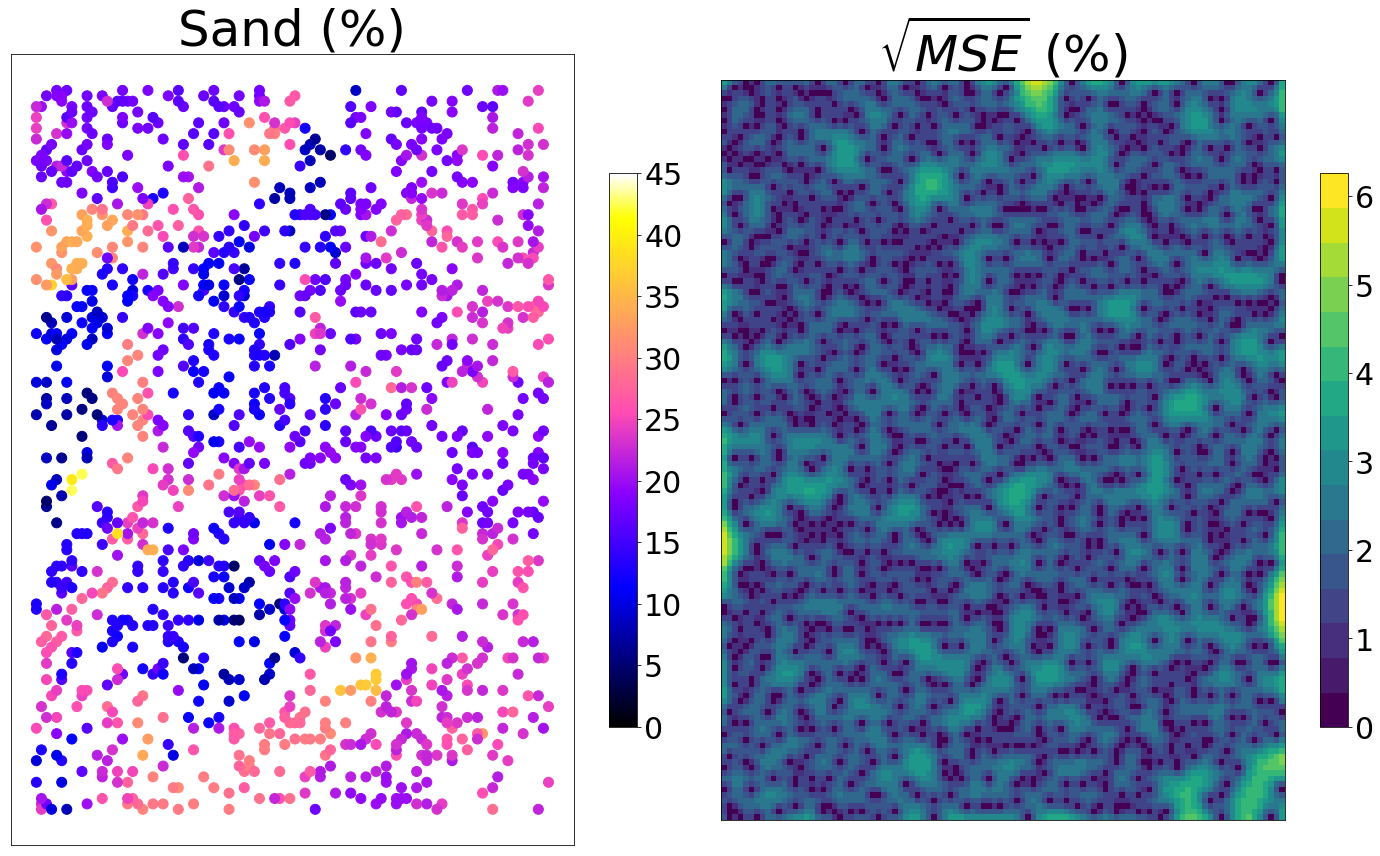

In [45]:
#Plot the original and kriged data side by side
mse_grid = mse.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(mse_grid,cmap=cm.get_cmap('viridis',16))
plt.xticks([])
plt.yticks([])
plt.title(r'$\sqrt{MSE}$ (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.scatter(ix,np.max(iy)-iy,c=data_points,s=100,vmin=vmin,vmax=vmax,cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()